Notebook investigates HERA layout with large dish spacings. 

In [1]:
%matplotlib inline
import numpy as n
import matplotlib.pyplot as p
import numpy.fft as fft
import scipy.signal as sig
import copy
import scipy
import healpy as hp
import cosmology
import aipy as a
import scipy.special as sp
import astropy.io.fits as fits
import getPower
import scipy.optimize as op
import scipy.signal as signal
import scipy.integrate as integrate
import scipy.interpolate as interp
pi=n.pi
c=299792458.
alphaGal=5.66
gammaGal=-.8
p0Gal=(10.**6.1)*(1e26*2.*1.38e-23/(c/150e6)**2.)**2.
r2=n.sqrt(2.)
littleh=.68
import capo.oqe as oqe

0.048252
[ 0.01051303  0.01766171  0.02492874 ...,  0.9296228   1.394404    1.945845  ]
(1316,)
(1316,)
(1316,)
[  4.5    4.5    4.5  ...,  34.38  34.38  34.38]
min klist
-1.97827209628


/Users/aaronew/Python/analysis/lib/python2.7/site-packages/capo/__init__.py:7: UserWarning: Warning: omnical not installed, not importing capo.omni
  warnings.warn("Warning: omnical not installed, not importing capo.omni")


In [2]:
def vGalaxy(u,f):
    return p0Gal*(f/150e66)**(2.*gammaGal)*u**(-alphaGal)
def varFlux(s,k,s0,gamma,smin=0.):
    return (k*s0**(gamma)*s**(-gamma+3))/(3-gamma)-(k*s0**(gamma)*smin**(-gamma+3))/(3-gamma)
def confusionLimit(sigPSF,k,s0,gamma,nsigma=5.):
    sAngle=2.*pi*sigPSF*sigPSF/(gamma-1)
    return (nsigma**(3-gamma)/(3-gamma))**(1/(gamma-1))*(k*s0**gamma*sAngle)**(1/(gamma-1))
def confusionVar(k,s0,gamma,sigPSF,nsigma=5):
    sConf=nsigma*confusionLimit(sigPSF,k,s0,gamma,nsigma)
    return varFlux(sConf,k,s0,gamma),sConf

def maxVar(k,s0,gamma,sa,sMaxInt=True):
    if(sMaxInt):
        aeff=pi*sa**2
        smax=(k*s0**gamma*aeff/(gamma-1))**(1/(gamma-1))
    else:
        aeff=2*pi*sa**2./(gamma-1)
        smax=((gamma-1)*s0**(-gamma)/(k*aeff))**(1./(1-gamma))
    return varFlux(smax,k,s0,gamma),smax
def kEvo(k,f,f0,gamma,delta):
    return k*(f/f0)**(delta*(1-gamma))

In [3]:
#data=n.load('/Users/aaronew/Dropbox/PRISim_Runs/hera_19_low_asm_fullday/2016-08-19-23-02-06/simdata/simvis.npz')
#data=n.load('../../data/14.0m_dish_multi_baseline_visibilities_no_ground_drift_80x1080.0s_baseline_range_14.6-58.4_asm_all_sky_sprms_0.0_nside_256_derr_0.000ns_gerr_0.00dB_nrand_1_Tsys_220.0K_128x781.2_kHz_150.0_MHz_extpb_DDAN_137.5_MHz_achromatic_no_pfb.npz')
#data=n.load('../../data/HERA-19_FG_delay_spectra.npz')
#workdir='/home/aaronew/Dropbox/simulat'
#beamP=n.load(workdir+'beamPs.npy')
data=n.load('/Users/aaronew/Dropbox (MIT)/Science/simulations-hera-eox/data/simulations/largeSpacings.npz')
beamP=0.0363576582083*n.ones((data['freq'].size,2))

In [4]:
print data.files
print data['skyvis_freq'].shape
print len(data['skyvis_freq'])
print len(data['bl_length'])
print data['freq'].shape
print data['freq'].min()
print data['freq'].max()

['vis_freq', 'bl', 'timestamp', 'skyvis_freq', 'bl_length', 'lst', 'vis_noise_freq', 'freq']
(30, 250, 24)
30
30
(250,)
50000000.0
149600000.0


In [5]:
fAxis=data['freq']
nf=len(fAxis)
print nf
cf=fAxis[nf/2]
df=fAxis[1]-fAxis[0]
tAxis=fft.fftshift(fft.fftfreq(nf,df))
keff=kEvo(4000,cf,150e6,2.5,.8)
vMax,sMax=maxVar(keff,.88,2.5,.45*c/cf/14.)
print sMax
print vMax

250
20.3687059616
42666.5863747


In [6]:
#multiply by blackman
window=sig.blackmanharris(nf);window/=n.sqrt(n.mean(window**2.))
vis_freq_windowed=copy.deepcopy(data['vis_freq'])
vis_freq_windowed_conv=copy.deepcopy(data['vis_freq'])
#antKernel=fft.fftshift(fft.fft(fft.fftshift(n.load('../data/fiducial_kernel_full_lowBand.npz')['bandInterp'])))
antKernel=n.ones(nf)
data_conv=copy.deepcopy(data['skyvis_freq'])
for mm in range(data_conv.shape[0]):
    for nn in range(data_conv.shape[2]):
        data_conv[mm,:,nn]*=antKernel
for mm in range(vis_freq_windowed.shape[0]):
    for nn in range(vis_freq_windowed.shape[2]):
        vis_freq_windowed[mm,:,nn]*=window
        vis_freq_windowed_conv[mm,:,nn]*=window
        vis_freq_windowed_conv[mm,:,nn]*=antKernel

#fourier transform visibilities
vis_delay=df*fft.fftshift(fft.fft(fft.fftshift(vis_freq_windowed[:,:,:2],axes=(1)),axis=(1)),axes=(1)).mean(axis=2)
vis_delay_conv=df*fft.fftshift(fft.fft(fft.fftshift(vis_freq_windowed_conv[:,:,:2],axes=(1)),axis=(1)),axes=(1)).mean(axis=2)

In [7]:
#multiply by blackman
window=sig.blackmanharris(nf);window/=n.sqrt(n.mean(window**2.))
vis_freq_windowed_all=copy.deepcopy(data['skyvis_freq'])
vis_freq_windowed_conv_all=copy.deepcopy(data['skyvis_freq'])
#antKernel=fft.fftshift(fft.fft(fft.fftshift(n.load('../data/fiducial_kernel_full_lowBand.npz')['bandInterp'])))
antKernel=n.ones(nf)
for mm in range(vis_freq_windowed.shape[0]):
    for nn in range(vis_freq_windowed.shape[2]):
        vis_freq_windowed_all[mm,:,nn]*=window
        vis_freq_windowed_conv_all[mm,:,nn]*=window
        vis_freq_windowed_conv_all[mm,:,nn]*=antKernel

#fourier transform visibilities
vis_delay_all=df*fft.fftshift(fft.fft(fft.fftshift(vis_freq_windowed_all[:,:,:2],axes=(1)),axis=(1)),axes=(1)).mean(axis=2)
vis_delay_conv_all=df*fft.fftshift(fft.fft(fft.fftshift(vis_freq_windowed_conv_all[:,:,:2],axes=(1)),axis=(1)),axes=(1)).mean(axis=2)


In [8]:
#data,window,kernel,area are all given in zero in center format real space.
def tsys(f):
    return 100.+60.*(c/f)**2.55
def gen_noise(fAxis,tau,ae):
    noiseAmp=n.sqrt(2.)*1.23e3*tsys(fAxis)/(ae*n.sqrt(tau*(fAxis[1]-fAxis[0])))
    return noiseAmp*(n.random.randn(len(fAxis))+1j*n.random.randn(len(fAxis)))

def gen_ps_signal(fAxis,uVal,beampp=1.,flux=True,ntimes=1):
    fc=fAxis[len(fAxis)/2]
    zc=cosmology.f2z(fc)
    delays=fft.fftshift(fft.fftfreq(len(fAxis),fAxis[1]-fAxis[0]))
    kParVals=cosmology.eta2kpara(delays,zc)
    kPerpVal=cosmology.u2kperp(uVal,zc)
    kvals=n.sqrt(kPerpVal**2.+kParVals**2.)
    stdPS=n.sqrt(getPower.ps21(n.abs(kvals),n.ones(len(kvals))*zc,flux=flux,beampp=beampp))
    #fit to power law and fill in where zero
    if(n.any(stdPS==0)):
        if( len(stdPS[stdPS==0])==1):
            posFit=n.logical_and(delays>0,delays<=500e-9)
            ppos,_=op.curve_fit(lambda x,a,b: a*n.abs(1+x)**b, delays[posFit],stdPS[posFit],p0=[n.std(stdPS),-1])
            stdPS[stdPS==0]=ppos[0]*(1+0)**ppos[1]
        else:
            isZero=stdPS==0
            minDelay=delays[isZero].max()
    #fit pos and neg
            posFit=n.logical_and(delays>minDelay,delays<=10*minDelay)
            negFit=n.logical_and(-delays>minDelay,-delays<=10*minDelay)
            ppos,_=op.curve_fit(lambda x,a,b: a*n.abs(1+x)**b, delays[posFit],stdPS[posFit],p0=[n.std(stdPS),-1])
            pneg,_=op.curve_fit(lambda x,a,b: a*n.abs(1+x)**b, delays[negFit],stdPS[negFit],p0=[n.std(stdPS),-1])
            posFill=n.logical_and(delays>=0,delays<=minDelay)
            stdPS[posFill]=ppos[0]*(1+delays[posFill])**ppos[1]
            negFill=n.logical_and(-delays>=0,-delays<=minDelay)
            stdPS[negFill]=pneg[0]*(1+delays[negFill])**pneg[1]
    psInstance=(n.random.randn(len(stdPS),ntimes)+1j*n.random.randn(len(stdPS),ntimes))/n.sqrt(2.)
    for mm in range(ntimes):
        psInstance[:,mm]*=stdPS
    return stdPS,psInstance


def delay_clean(data,window,kernel,area,tol=1e-3,gain=.1,maxiter=1000):
    dDelay=fft.ifft(data*window)
    dKernel=fft.ifft(kernel)
    area=fft.fftshift(area)
    cc,info=a.deconv.clean(dDelay,dKernel,area=area,tol=tol,gain=gain,maxiter=maxiter,stop_if_div=False,verbose=False)
    return fft.fft(info['res'])

def delay_clean_gentle(data,window,kernel,area,noiseArea,nsigma=3.):
    #double area for noise area
    
    dDelay=fft.ifft(data*window)
    dKernel=fft.ifft(kernel)
    area=fft.fftshift(area).astype(int)
    noiseArea=fft.fftshift(noiseArea).astype(int)
    noiseSTD=n.sqrt(n.mean(n.abs(dDelay[noiseArea==0])**2.))
    signalSTD=n.sqrt(n.mean(n.abs(dDelay[noiseArea==1]))**2.)
    good=signalSTD>=nsigma*noiseSTD
    iters=0
    #print good
    #print noiseSTD
    #print signalSTD
    while(good):
        iters+=1
        cc,info=a.deconv.clean(dDelay,dKernel,area=area,tol=1e-1,gain=.1,maxiter=int(1e3),stop_if_div=False,verbose=False)
        signalSTD=n.sqrt(n.mean(n.abs(info['res'][noiseArea==1])**2.))
        noiseSTD=n.sqrt(n.mean(n.abs(info['res'][noiseArea==0])**2.))
        good=signalSTD>=nsigma*noiseSTD
        if(good):
            dDelay=info['res']

    #print iters 
    return fft.fft(dDelay)

In [9]:
def empCov_avgLST(foregrounds,rFactor=1e-10):
    empCov=n.zeros((foregrounds.shape[0],foregrounds.shape[1],foregrounds.shape[1]),dtype=complex)
    empCovI=n.zeros_like(empCov)
    mu_foregrounds=n.mean(foregrounds,axis=-1)
    for mm in range(foregrounds.shape[0]):
        for nn in range(foregrounds.shape[-1]):
            empCov[mm,:,:]+=n.outer(foregrounds[mm,:,nn]-mu_foregrounds[mm,:],n.conj(foregrounds[mm,:,nn]-mu_foregrounds[mm,:]))
        empCov[mm,:,:]/=foregrounds.shape[-1]
        empCov[mm,:,:]+=n.identity(foregrounds.shape[1])*rFactor*n.abs(n.linalg.eig(empCov[mm,:,:])[0]).max()
        empCovI[mm,:,:]=n.linalg.inv(empCov[mm,:,:])
    return empCov,empCovI
        

In [10]:
#generate beam factor for covariance matrix
def covBeam(beamFile,maxVal,nPoints=200,azimuthAvg=True,nPhi=200,nTh=200):
    data=fits.open(beamFile)[1].data
    thetaVals=n.linspace(0.,pi/2.,nTh)
    phiVals=n.linspace(0.,2.*pi,nPhi)
    avgVec=n.zeros((nTh,nPhi))
    phG,thG=n.meshgrid(phiVals,thetaVals)
    avgVec=hp.get_interp_val(data**2.,thG,phG).mean(axis=1)
    integrandInt=interp.interp1d(thetaVals,avgVec)
    bdelayAxis=n.linspace(0,maxVal,nPoints)
    interpVec=n.zeros(nPoints)
    for mm in range(nPoints):
        interpVec[mm]=2.*n.pi*integrate.quad(lambda x: n.sin(x)*sp.j0(2*pi*n.sin(x)*bdelayAxis[mm])*integrandInt(x),
                                     0,
                                     pi/2,
                                    epsabs=1e-8,
                                    epsrel=1e-8,
                                    limit=50)[0]
    interpFunc=interp.interp1d(bdelayAxis,interpVec)
    return interpFunc
#generate covariance matrix for point sources
def covariancePointSources(vS,b,dfVals,covBeamFunc,buf=0):#deal with non-azimuthally symmetric beams?
    print 'b/c=%e'%(b/c)
    return vS*covBeamFunc((b/c+buf)*dfVals)
    
#generate galaxy covariance
def covarianceGalaxy(b,dfVals,covBeamFunc,f0,buf=0):
    print 'b/c=%e'%(b/c)
    return covBeamFunc((b/c+buf)*dfVals)*vGalaxy(b/c*f0,f0)


In [11]:
#optimal quadratic estimator routine
#x: visibility vector
#wF: tapering function
#cInv: covariance matrix of visibility vector
#mode: normalization to use. 
def oqeFunc(x,wF=None,cInv=None,mode='F^-1/2'):
    modes=['F^-1','F^-1/2','L^-1','I']; assert(mode in modes)
    nf=len(x)
    if(cInv is None):
        cInv=n.identity(nf)
    if(wF is None):
        wF=n.ones(nf)
    qMatrices=n.zeros((nf,nf,nf),dtype=complex)
    qHat=n.zeros(nf,dtype=complex)
    pHat=n.zeros(nf,dtype=complex)
    wMat=n.zeros(nf,dtype=complex)
    mMat=n.zeros((nf,nf),dtype=complex)
    fMat=n.zeros((nf,nf),dtype=complex)
    #construct q matrices
    z=n.dot(cInv,x)
    #construct qhat
    for mm in range(nf):
        _m=n.zeros(nf)
        _m[mm]=1.
        m=fft.fft(fft.ifftshift(_m))
        qMat=n.einsum('i,j',m,m.conj())
        qMatrices[mm,:,:]=qMat
        qHat[mm]=n.dot(n.conj(z).T,n.dot(qMat,z))
    #construct fMat
    for mm in range(nf):
        for nn in range(nf):
            ftq=n.dot(cInv,n.dot(qMatrices[mm,:,:],n.dot(cInv,qMatrices[nn,:,:])))
            fMat[mm,nn]=n.trace(ftq)
    
    #print 'fMat condition=%e'%(n.linalg.cond(fMat))
    #if(n.linalg.cond(fMat)>1e10):
    #    fMat+=n.identity(fMat.shape[1])*1e-10*n.abs(n.linalg.eig(fMat)[0]).max()
    #    print 'regularized fMat condition=%e'%(n.linalg.cond(fMat))

    

    #construct mMat
    if(mode=='F^-1'):
        mMat=n.linalg.inv(fMat)
    elif(mode=='F^-1/2'):
        U,S,V=n.linalg.svd(fMat.conj())
        mMat=n.einsum('ij,j,jk',U.T,1./n.sqrt(S),V.T)
        fMatSqrt=scipy.linalg.sqrtm(fMat)
        #print 'Condition of Sqrt-F-matrix=%e'%(n.linalg.cond(fMatSqrt))
        mMat=n.linalg.inv(fMatSqrt)
    elif(mode=='L^-1'):
        order=n.zeros(nf)
        order[0]=nf/2
        order[1]=nf/2+1
        order[2]=nf/2-1
        order[3]=nf/2+2
        order[4]=nf/2-2
        order[5]=nf-1
        order[6]=0
        for mm in range(4,nf/2):
            order[2*mm-1]=nf/2+mm-1
            order[2*mm]=nf/2-mm+1
        order[-1]=1
        order=order.astype(int)
        #order = n.array([10,11,9,12,8,20,0,13,7,14,6,15,5,16,4,17,3,18,2,19,1]) # XXX needs generalizing
        iorder = n.argsort(order)
        fMat_o = n.take(n.take(fMat,order, axis=0), order, axis=1)
        lMat_o = n.linalg.cholesky(fMat_o)
        #print 'Condition of L-matrix=%e'%(n.linalg.cond(lMat_o))
        U,S,V = n.linalg.svd(lMat_o.conj())
        mMat_o = n.dot(n.transpose(V), n.dot(n.diag(1./S), n.transpose(U)))      
        mMat = n.take(n.take(mMat_o,iorder, axis=0), iorder, axis=1)
    elif(mode=='I'):
        mMat=n.identity(nf,dtype=complex)
        
    wMat=n.dot(mMat,fMat)
    norm  = wMat.sum(axis=-1); norm.shape += (1,)
    mMat/=norm; wMat=n.dot(mMat,fMat)
    pHat=n.dot(mMat,qHat)
    sigmaHat=n.dot(n.dot(mMat,fMat),mMat.T)
    return qHat,pHat,sigmaHat,fMat,qMatrices




In [12]:
#iterate through all LSTs, clean and store residual. 
c=3e8
littleh=.68
resid=[]
conv_resid=[]
z=cosmology.f2z(data['freq'][nf/2])
delays=fft.fftshift(fft.fftfreq(nf,df))
noise=gen_noise(data['freq'],20.*60.,75.)
kernel=n.ones(nf)
maxdelay_list=[]
for mm in range(data['skyvis_freq'].shape[0]):
    bl_list=[]
    bl_list_conv=[]
    #for nn in range(data['skyvis_freq'].shape[2]):
    for nn in range(data['lst'].size):

    #psSignalModel,psSignal=gen_ps_signal(freqs,uvwLen[mm]/3e8*fc,beamP[nf/2,1]*df*len(freqs))
    #psSignalVis=fft.fftshift(fft.ifft(fft.fftshift(psSignal)))/df
        hdelay=data['bl_length'][mm]/c
        maxdelay=hdelay+cosmology.kpara2eta(0.05*littleh,z)
        area=n.zeros(nf)
        area[n.abs(delays)<maxdelay]=1.
        noiseArea=n.zeros(len(area))
        noiseArea[n.abs(delays)<1.*maxdelay]=1.
        temp_conv=delay_clean_gentle(data_conv[mm,:,nn]+noise,window,kernel,area,noiseArea,nsigma=3)
        temp=delay_clean_gentle(data['skyvis_freq'][mm,:,nn]+noise,window,kernel,area,noiseArea,nsigma=3)
        maxdelay_list.append(maxdelay)
        bl_list_conv.append((temp_conv-noise*window)/window)
        bl_list.append((temp-noise*window)/window)
    resid.append(copy.deepcopy(bl_list))
    conv_resid.append(copy.deepcopy(bl_list_conv))
    

resid=n.array(resid)
conv_resid=n.array(conv_resid)

resid=n.swapaxes(resid,1,-1)
conv_resid=n.swapaxes(conv_resid,1,-1)

In [13]:
def delayTransform(vis,df,window='blackman-harris'):
    if window=='blackman-harris':
        window=signal.blackmanharris(vis.shape[0])
    #window=signal.fftconvolve(window,window,mode='full')
    #window=n.append(window,0)
    elif window=='blackman-conv':
        nf=len(vis)
        window=signal.blackmanharris(nf/2)
        window=signal.fftconvolve(window,window,mode='full')
        window=n.append(window,window[-1])
    window/=n.sqrt(n.mean(window**2.))
    if(len(vis.shape)>1):
        windowx,windowy=n.meshgrid(range(vis.shape[1]),window)
        return window,n.fft.fftshift(n.fft.fft((vis*windowy).conj(),axis=0),axes=0)*df
    else:
        return window,n.fft.fftshift(n.fft.fft((vis*window).conj(),axis=0),axes=0)*df
    
def delay2PS(vis,beamP,band,f0):
    #convert to temperature power spectrum
    output=n.zeros_like(vis)
    if(len(vis.shape)>1):
        for mm in range(vis.shape[1]):
            output[:,mm]=vis[:,mm]/n.sqrt(beamP*band)
    else:
        output=vis/n.sqrt(beamP*band)
    output=littleh**3.*(cosmology.X(f0)**2.*cosmology.Y(f0)*n.abs(cosmology.i2t(f0,output))**2.)*1e6
    return output

def delayTransformList(vislist,df,window='blackman-harris'):
    output=[]
    windows=[]
    for mm in range(len(vislist)):
        dT=delayTransform(vislist[mm],df,window=window)
        windows.append(dT[0])
        output.append(dT[1])
    return output,windows

def delay2PSList(vislist,beamlist,bandlist,flist):
    output=[]
    for mm in range(len(vislist)):
        output.append(delay2PS(vislist[mm],beamlist[mm],bandlist[mm],flist[mm]))
    return output

/Users/aaronew/Python/analysis/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/Users/aaronew/Python/analysis/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


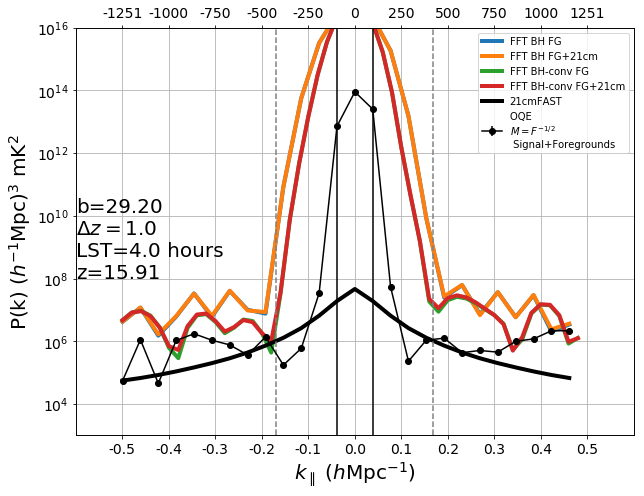

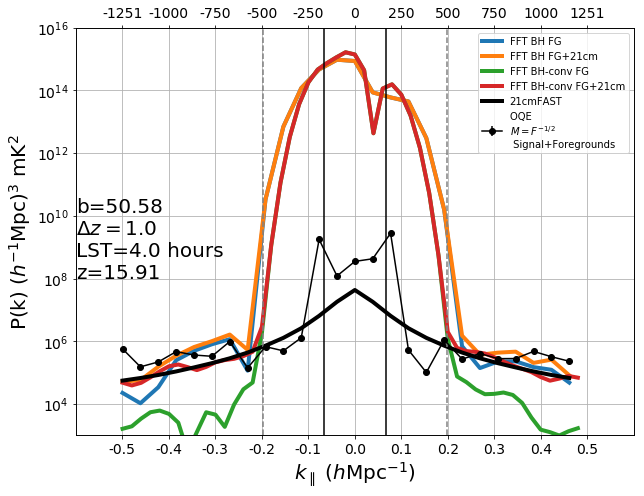

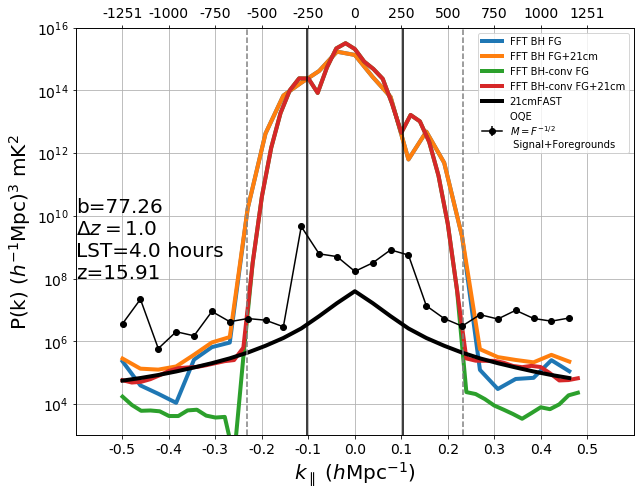

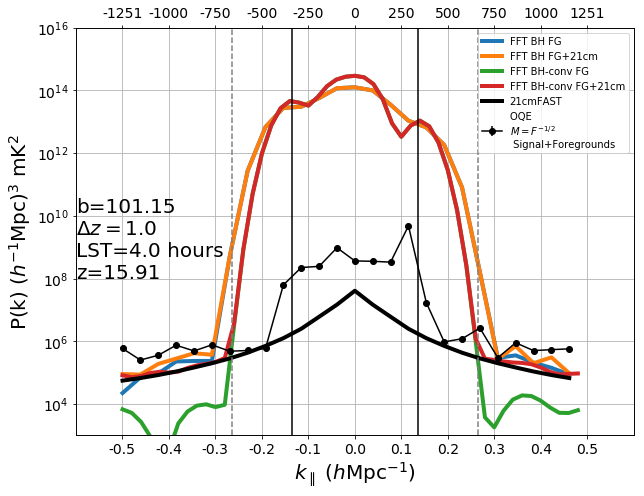

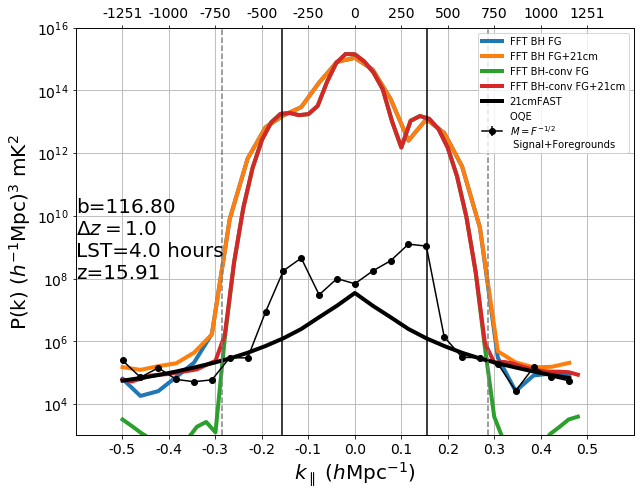

In [35]:
nPSAvg=20
for blindex in [0,5,9,19,29]:
    freqs=data['freq']
    lst=60.
    delta_z=1.0
    lstbin=n.where(n.abs(data['lst']-lst)==n.abs(data['lst']-lst).min())[0][0]
    zcList=n.array([16.])
    fcList=cosmology.z2f(zcList)
    fcList=cosmology.z2f(zcList)
    uvw_l=data['bl_length'][blindex]*c/fcList[0]
    bwidths=-cosmology.dz2df(2*delta_z,zcList)
    bwidths_c=2.*bwidths
    flows_c=fcList-bwidths_c/2
    fhighs_c=fcList+bwidths_c/2
    flows=fcList-bwidths/2
    fhighs=fcList+bwidths/2
    mm=0
    select=n.logical_and(freqs>flows[mm],freqs<=fhighs[mm])
    select_c=n.logical_and(freqs>flows_c[mm],freqs<=fhighs_c[mm])
    freqs_select=freqs[select]
    freqs_select_c=freqs[select_c]
    nfs=len(freqs_select)
    nfs_c=len(freqs_select_c)
    if(n.mod(nfs,2)==1):
            maxind=n.where(select)[0].max()
            select[maxind+1]=True
            nfs+=1
            freqs_select=freqs[select]
    if(n.mod(nfs_c,2)==1):
            maxind=n.where(select_c)[0].max()
            select_c[maxind+1]=True
            nfs_c+=1
            freqs_select_c=freqs[select_c]        

    band_select=(freqs_select.max()-freqs_select.min())
    band_select_c=(freqs_select_c.max()-freqs_select_c.min())

    delayList=n.arange(-(nfs-1)/2,(nfs-1)/2+1)/(nfs*df)
    delayList_c=n.arange(-(nfs_c-1)/2,(nfs_c-1)/2+1)/(nfs_c*df)


    fGrid,fGridp=n.meshgrid(freqs_select,freqs_select)
    fGrid_c,fGridp_c=n.meshgrid(freqs_select_c,freqs_select_c)
    ps_fft_fg=n.zeros(nfs);ps_cfft_fg=n.zeros(nfs_c);ps_fft_fgs=n.zeros(nfs)
    ps_cfft_fgs=n.zeros(nfs_c);ps_oqe=n.zeros(nfs);ps_sig=n.zeros(nfs)

    for psIndex in range(nPSAvg):
        psSignalModels=n.zeros((1,nfs))
        psSignalModels_c=n.zeros((1,nfs_c))
        psSignalInstances=n.zeros_like(data['skyvis_freq'][:,select,lstbin])
        psSignalInstances_c=n.zeros_like(data['skyvis_freq'][:,select_c,lstbin])

     
        psSignalModels,psSignalInstances=gen_ps_signal(freqs_select,data['bl_length'][blindex]/3e8*fcList[0],beamP[nf/2,1]*df*nfs,ntimes=data['lst'].shape[0])
        psSignalModels_c,psSignalInstances_c=gen_ps_signal(freqs_select_c,data['bl_length'][blindex]/3e8*fcList[0],beamP[nf/2,1]*df*nfs_c,ntimes=data['lst'].shape[0])
        psSignalViss=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances,axes=[0]),axis=0),axes=[0])/(df)
        psSignalViss_c=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances_c,axes=[0]),axis=0),axes=[0])/(df)
        #print(psSignalModels.shape);print(psSignalViss.shape);print(psSignalViss_c.shape)
        psSignalVis=psSignalViss
        psSignalVis_c=psSignalViss_c
        #print psSignalVis.shape
        #print psSignalVis_c.shape
        windowSignal,dtrans_signal=delayTransform(psSignalVis,df,window=n.ones(nfs))
        windowSignal_c,dtrans_signal_c=delayTransform(psSignalVis_c,df,window=n.ones(nfs_c))
        psSig=delay2PS(dtrans_signal,beamP[select,1][nfs/2],band_select,fcList[0])
        psSig_c=delay2PS(dtrans_signal_c,beamP[select_c,1][nfs_c/2],band_select_c,fcList[0])

        lstSelect=n.logical_and(data['lst']>0, data['lst']<360.)

        #print 'computing data covariance'
        fgCov,fgCovI=empCov_avgLST(data['skyvis_freq'][:,select,:][:,:,lstSelect]+1*psSignalViss[:,lstSelect],rFactor=0)
        #print 'compute resid covariance'
        fgCovR,fgCovIR=empCov_avgLST(resid[:,select,:][:,:,lstSelect]+1*psSignalViss[:,lstSelect],rFactor=0)


        fgCov=fgCov[blindex].squeeze()
        fgCovI=fgCovI[blindex].squeeze()
        fgCovIR=fgCovIR[blindex].squeeze()


        myMode='F^-1/2'
        
        psSignalVis=psSignalVis[:,lstbin]
        psSignalVis_c=psSignalVis_c[:,lstbin]
        
        qHatR,pHatR,wMatR,fMatR,qMatrices=oqeFunc(resid[blindex,select,lstbin]+1*psSignalVis,cInv=fgCovIR,mode=myMode)

        qHat,pHat,wHat,_,_=oqeFunc(data['skyvis_freq'][blindex,select,lstbin]+1*psSignalVis,wF=sig.blackmanharris(nfs),cInv=fgCovI,mode=myMode)

        qHatT,pHatT,_,_,_=oqeFunc(psSignalVis,wF=n.ones(nfs),cInv=None,mode='I')

        pHatB=n.sqrt(pHat*(df*nfs)**2.)
        pHatB_e=n.sqrt(n.sqrt(n.abs(n.diagonal(wHat)))*(df*nfs)**2.)
        pHatBR=n.sqrt(pHatR*(df*nfs)**2.)
        pHatBT=n.sqrt(pHatT*(df*nfs)**2.)


        pHatPS=delay2PS(pHatB,beamP[0,0],band_select,fcList[0])
        pHatPS_e=delay2PS(pHatB_e,beamP[0,0],band_select,fcList[0])

        pHatPSR=delay2PS(pHatBR,beamP[0,0],band_select,fcList[0])
        pHatPST=delay2PS(pHatBT,beamP[0,0],band_select,fcList[0])


        nFactorResponse=n.sqrt(n.mean(n.abs(antKernel)[n.logical_and(freqs>flows[0],freqs<=fhighs[0])]**2.))/n.sqrt(n.mean(n.abs((antKernel)[select])**2.))
        nFactor=1.#np.abs(window).max()/np.abs((window)[select]).max()
        nFactorResponse=1.
        fcs=freqs_select[len(freqs_select)/2]

        dtrans_list,_=delayTransformList([data['skyvis_freq'][[blindex],select,lstbin].T*nFactor],df)
        dtrans_list_bh2,_=delayTransformList([data['skyvis_freq'][[blindex],select_c,lstbin].T*nFactor],df,window='blackman-conv')
        dtrans_list_sig,_=delayTransformList([data['skyvis_freq'][[blindex],select,lstbin].T*nFactor+psSignalVis],df)
        dtrans_list_sig_bh2,_=delayTransformList([data['skyvis_freq'][[blindex],select_c,lstbin].T*nFactor+psSignalVis_c],df,window='blackman-conv')
        #dtrans_conv_list,_=delayTransformList([data_conv[:,select,lstbin].T*nFactorResponse],df)
        #dtrans_conv_list_bh2,_=delayTransformList([data_conv[:,select_c,lstbin].T*nFactorResponse],df,window='blackman-conv')
        #dtrans_resid_list,_=delayTransformList([resid[:,select,lstbin].T*nFactor],df)
        #dtrans_resid_list_bh2,_=delayTransformList([resid[:,select_c,lstbin].T*nFactor],df,window='blackman-conv')
        #dtrans_conv_resid_list,windows=delayTransformList([conv_resid[:,select,lstbin].T*nFactorResponse],df)
        #dtrans_conv_resid_list_bh2,_=delayTransformList([conv_resid[:,select_c,lstbin].T*nFactorResponse],df,window='blackman-conv')

        ps_list=delay2PSList(dtrans_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        ps_list_sig=delay2PSList(dtrans_list_sig,[beamP[select,1][nfs/2]],[band_select],[fcs])
        ps_list_bh2=delay2PSList(dtrans_list_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        ps_list_sig_bh2=delay2PSList(dtrans_list_sig_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        #ps_conv_list=delay2PSList(dtrans_conv_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        #ps_conv_list_bh2=delay2PSList(dtrans_conv_list_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        #ps_resid_list=delay2PSList(dtrans_resid_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        #ps_resid_list_bh2=delay2PSList(dtrans_resid_list_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        #ps_conv_resid_list=delay2PSList(dtrans_conv_resid_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        #ps_conv_resid_list_bh2=delay2PSList(dtrans_conv_resid_list_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        z0=cosmology.f2z(fcs)

        #tuvw=data['bl_length'][:,lstbin]
        #print tuvw
        #uvw_l=n.sqrt(n.sum(tuvw**2.))/c*freqs_select[nfs/2]
        #print uvw_l
        #signalPS=gen_ps_signal(freqs_select,uvw_l,beamP[select,1][nfs/2],flux=False)
        #signalPS=signalPS[0]*signalPS[0]*littleh**3.
        
        ps_fft_fg+=ps_list[0][:]
        ps_cfft_fg+=ps_list_bh2[0][:]
        ps_fft_fgs+=ps_list_sig[0][:]
        ps_cfft_fgs+=ps_list_sig_bh2[0][:]
        ps_oqe+=pHatPS
        ps_sig+=psSig[:,lstbin]
    ps_fft_fg/=nPSAvg;ps_cfft_fg/=nPSAvg;
    ps_fft_fgs/=nPSAvg;ps_cfft_fgs/=nPSAvg;
    ps_oqe/=nPSAvg;ps_sig/=nPSAvg
    
    fig=p.figure()
    ax1=fig.add_subplot(111)

    kList=cosmology.eta2kpara((delayList),z0)
    #kList=n.sign(kList)*n.sqrt(kList**2.+cosmology.u2kperp(uvw_l,z0)**2.)
    kList_c=cosmology.eta2kpara((delayList_c),z0)
    #kList_c=n.sign(kList_c)*n.sqrt(kList_c**2.+cosmology.u2kperp(uvw_l,z0)**2.)
    l0=ax1.plot(kList/littleh,ps_fft_fg,label='FFT BH FG',lw=4)[0]
    l2=ax1.plot(kList/littleh,ps_fft_fgs,label='FFT BH FG+21cm',lw=4)[0]
    l1=ax1.plot(kList_c/littleh,ps_cfft_fg,label='FFT BH-conv FG',lw=4)[0]
    l3=ax1.plot(kList_c/littleh,ps_cfft_fgs,label='FFT BH-conv FG+21cm',lw=4)[0]

    #l1=ax1.plot(kList/littleh,ps_conv_list[0][:,blindex],label='Beam\n with Response Function',lw=4)[0]

    #l2=ax1.plot(kList/littleh,ps_resid_list[0][:,blindex],label='FFT Power Spectrum\nClean Residuals',ls='--',lw=4)[0]
    #l3=ax1.plot(kList/littleh,ps_conv_resid_list[0][:,blindex],label='Residuals\n with Reflection',ls='--',lw=4)[0]

    #l6=ax1.plot(kList/littleh,pHatPSR,label='Empirical Covariance\n$M=F^{-1/2}$ \n Signal+Clean Residuals',color='grey',marker='d',markersize=10)[0]
    l4=ax1.errorbar(kList/littleh,pHatPS,pHatPS_e,label='OQE \n$M=F^{-1/2}$ \n Signal+Foregrounds',color='k',marker='o')[0]

    #l5=ax1.errorbar(kList/littleh,psSig[:,lstbin],psSig[:,lstbin],label='FFT Power Spectrum\nSignal Only',color='m',marker='d',markersize=10)[0]


    #l7=ax1.plot(kList/littleh,pHatPST,label='Identity Covariance\nIdentity M\n Signal Only',color='m',marker='d',markersize=10)[0]


    #l8=ax1.plot(kList/littleh,pHatPSAP[:,lstbin],label='ap',color='orange',marker='d',markersize=10)[0]
    #l9=ax1.plot(kList/littleh,pHatPSAPI,label='ap',color='orange',marker='o',markersize=10)[0]
    #l10=ax1.plot(kList/littleh,pHatPSAPT[:,lstbin],label='Identity Covarianc\nIdentity M\nSignal Only',color='red',marker='*',markersize=10)[0]


    hz=cosmology.eta2kpara(uvw_l/freqs_select[nfs/2],z0)/littleh
    psSignalModels=delay2PS(psSignalModels,beamP[select,1][nfs/2],band_select,fcs)
    ls=ax1.plot(kList[::]/littleh,psSignalModels,color='k',lw=4,label='21cmFAST')[0]

    ax1.set_yscale('log')

    ax1.set_xlabel('$k_\parallel$ ($h$Mpc$^{-1}$)',fontsize=20)
    ax1.set_ylabel('P(k) ($h^{-1}$Mpc)$^{3}$ mK$^2$',fontsize=20)
    #        ax1.set_title('z=%.1f,u=%.1f$\\lambda$'%(cosmology.f2z(fcs),uvw_l),fontsize=30,y=1.1)
    ax1.tick_params('x',labelsize=14)
    ax1.tick_params('y',labelsize=14)

    ax1.axvline((cosmology.eta2kpara(data['bl_length'][blindex]/c,z0))/littleh,color='k',ls='-')
    ax1.axvline(-(cosmology.eta2kpara(data['bl_length'][blindex]/c,z0))/littleh,color='k',ls='-')


    ax1.axvline((cosmology.eta2kpara(325e-9+data['bl_length'][blindex]/c,z0))/littleh,color='grey',ls='--')
    ax1.axvline(-(cosmology.eta2kpara(325e-9+data['bl_length'][blindex]/c,z0))/littleh,color='grey',ls='--')
    
    ax1.grid(b=True,which='major')
    ax1.grid(b=True,which='minor')
    #ax1.text(.2,1.5e11,'z=%.1f'%(zcList[0]),fontsize=16)
    p.legend(loc='best',ncol=1,fontsize=10)
    tickset=n.arange(-5,6)*.1
    ax1.set_xticks(tickset)
    labels=[]
    for tick in tickset:
            labels.append(str(tick))


    ax1.set_xticklabels(labels)
    ax1.set_ylim(1e3,1e16)

    ax2=ax1.twiny()
    ticks=ax1.get_xticks()
    labels=[]
    for tick in ticks:
        labels.append('%d'%(1e9*cosmology.kpara2eta(littleh*tick,cosmology.f2z(fcs))))
    ax2.set_xticks(ticks)
    ax1.set_xlim(-.6,.6)
    ax2.set_xlim(ax1.get_xlim())
    #if(ii==0):
    #    ax2.set_xlabel('delay (ns)',fontsize=20)
    ax2.set_xticklabels(labels)
    ax2.tick_params('x',labelsize=14)
    ax2.tick_params('y',labelsize=14)
    #ax1.axvline(1/littleh*cosmology.eta2kpara(maxdelay_list[blindex],zcList[mm]),color='k',ls='--')
    #ax1.axvline(-1/littleh*cosmology.eta2kpara(maxdelay_list[blindex],zcList[mm]),color='k',ls='--')
    #ax1.text(0.,1e15,'%.1f m E-W, %.1f m N-S'%(data['bl'][2,0],data['bl'][2,1]),fontsize=24,ha='center')
    #axarr[0][1].text(0.,1e18,'%.1f m E-W, %.1f m N-S'%(data['bl'][blindices[1],0],data['bl'][blindices[1],1]),fontsize=24,ha='center')

    #ax1.legend((l0,l1,ls),('Achromatic\n Beam','Beam with\n Response\n Function','HI signal'),'upper left',ncol=1,fontsize=14)#,bbox_to_anchor=[.45,.03])
    fig.set_size_inches(10,7.5)
    ax1.text(-0.6,1e8,'b=%.2f\n$\\Delta z=%.1f$\nLST=%.1f hours\nz=%.2f'%(data['bl_length'][blindex],delta_z,lst/15.,z0),fontsize=20)
    p.savefig('/Users/aaronew/Dropbox_MIT/Science/simulations-hera-eox/analysis/delay_ps_z%.2f_len%.2f_lst_%.2fh_delta_z_%.2f.pdf'%(z0,
                                                                                                                        data['bl_length'][blindex],
                                                                                                                        lst/15.,delta_z),
                                                                                                                        bbox_inches='tight')
    p.show() 

/Users/aaronew/Python/analysis/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/Users/aaronew/Python/analysis/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


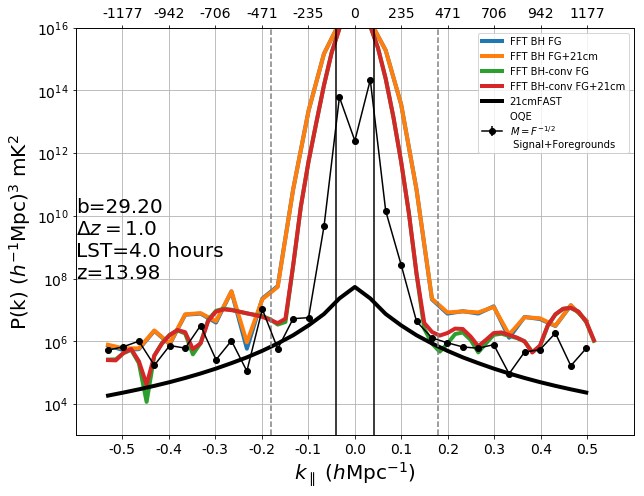

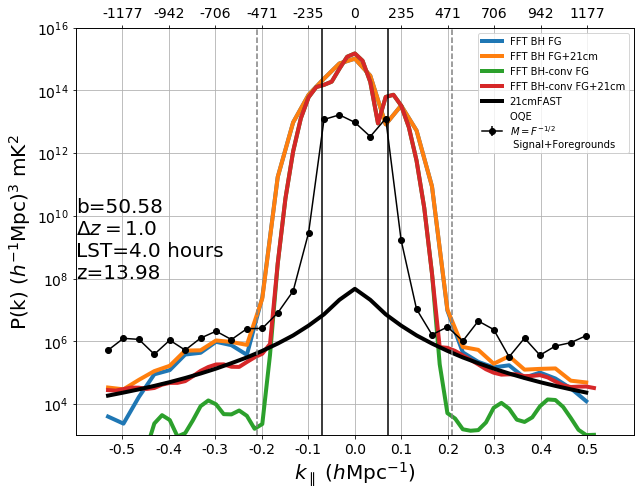

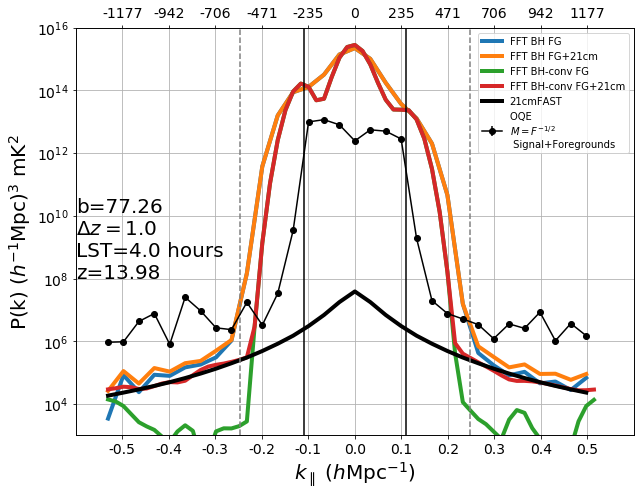

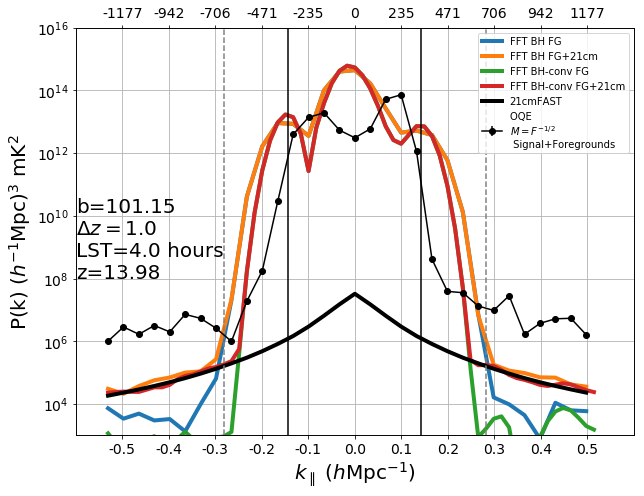

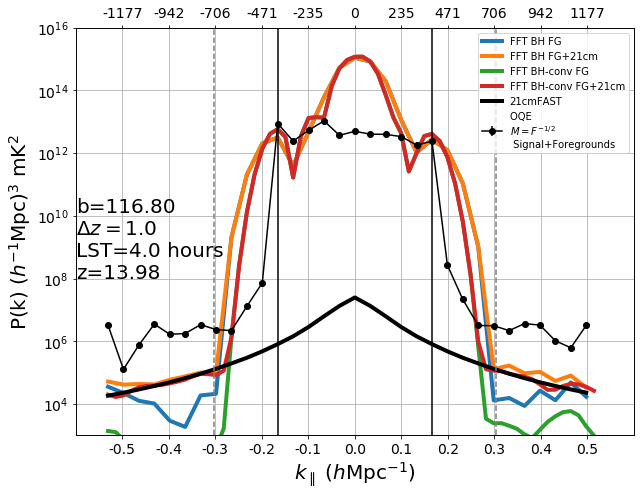

In [34]:
nPSAvg=20
for blindex in [0,5,9,19,29]:
    freqs=data['freq']
    lst=60.
    delta_z=1.0
    lstbin=n.where(n.abs(data['lst']-lst)==n.abs(data['lst']-lst).min())[0][0]
    zcList=n.array([14.])
    fcList=cosmology.z2f(zcList)
    fcList=cosmology.z2f(zcList)
    uvw_l=data['bl_length'][blindex]*c/fcList[0]
    bwidths=-cosmology.dz2df(2*delta_z,zcList)
    bwidths_c=2.*bwidths
    flows_c=fcList-bwidths_c/2
    fhighs_c=fcList+bwidths_c/2
    flows=fcList-bwidths/2
    fhighs=fcList+bwidths/2
    mm=0
    select=n.logical_and(freqs>flows[mm],freqs<=fhighs[mm])
    select_c=n.logical_and(freqs>flows_c[mm],freqs<=fhighs_c[mm])
    freqs_select=freqs[select]
    freqs_select_c=freqs[select_c]
    nfs=len(freqs_select)
    nfs_c=len(freqs_select_c)
    if(n.mod(nfs,2)==1):
            maxind=n.where(select)[0].max()
            select[maxind+1]=True
            nfs+=1
            freqs_select=freqs[select]
    if(n.mod(nfs_c,2)==1):
            maxind=n.where(select_c)[0].max()
            select_c[maxind+1]=True
            nfs_c+=1
            freqs_select_c=freqs[select_c]        

    band_select=(freqs_select.max()-freqs_select.min())
    band_select_c=(freqs_select_c.max()-freqs_select_c.min())

    delayList=n.arange(-(nfs-1)/2,(nfs-1)/2+1)/(nfs*df)
    delayList_c=n.arange(-(nfs_c-1)/2,(nfs_c-1)/2+1)/(nfs_c*df)


    fGrid,fGridp=n.meshgrid(freqs_select,freqs_select)
    fGrid_c,fGridp_c=n.meshgrid(freqs_select_c,freqs_select_c)
    ps_fft_fg=n.zeros(nfs);ps_cfft_fg=n.zeros(nfs_c);ps_fft_fgs=n.zeros(nfs)
    ps_cfft_fgs=n.zeros(nfs_c);ps_oqe=n.zeros(nfs);ps_sig=n.zeros(nfs)

    for psIndex in range(nPSAvg):
        psSignalModels=n.zeros((1,nfs))
        psSignalModels_c=n.zeros((1,nfs_c))
        psSignalInstances=n.zeros_like(data['skyvis_freq'][:,select,lstbin])
        psSignalInstances_c=n.zeros_like(data['skyvis_freq'][:,select_c,lstbin])

     
        psSignalModels,psSignalInstances=gen_ps_signal(freqs_select,data['bl_length'][blindex]/3e8*fcList[0],beamP[nf/2,1]*df*nfs,ntimes=data['lst'].shape[0])
        psSignalModels_c,psSignalInstances_c=gen_ps_signal(freqs_select_c,data['bl_length'][blindex]/3e8*fcList[0],beamP[nf/2,1]*df*nfs_c,ntimes=data['lst'].shape[0])
        psSignalViss=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances,axes=[0]),axis=0),axes=[0])/(df)
        psSignalViss_c=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances_c,axes=[0]),axis=0),axes=[0])/(df)
        #print(psSignalModels.shape);print(psSignalViss.shape);print(psSignalViss_c.shape)
        psSignalVis=psSignalViss
        psSignalVis_c=psSignalViss_c
        #print psSignalVis.shape
        #print psSignalVis_c.shape
        windowSignal,dtrans_signal=delayTransform(psSignalVis,df,window=n.ones(nfs))
        windowSignal_c,dtrans_signal_c=delayTransform(psSignalVis_c,df,window=n.ones(nfs_c))
        psSig=delay2PS(dtrans_signal,beamP[select,1][nfs/2],band_select,fcList[0])
        psSig_c=delay2PS(dtrans_signal_c,beamP[select_c,1][nfs_c/2],band_select_c,fcList[0])

        lstSelect=n.logical_and(data['lst']>0, data['lst']<360.)

        #print 'computing data covariance'
        fgCov,fgCovI=empCov_avgLST(data['skyvis_freq'][:,select,:][:,:,lstSelect]+1*psSignalViss[:,lstSelect],rFactor=0)
        #print 'compute resid covariance'
        fgCovR,fgCovIR=empCov_avgLST(resid[:,select,:][:,:,lstSelect]+1*psSignalViss[:,lstSelect],rFactor=0)


        fgCov=fgCov[blindex].squeeze()
        fgCovI=fgCovI[blindex].squeeze()
        fgCovIR=fgCovIR[blindex].squeeze()


        myMode='F^-1/2'
        
        psSignalVis=psSignalVis[:,lstbin]
        psSignalVis_c=psSignalVis_c[:,lstbin]
        
        qHatR,pHatR,wMatR,fMatR,qMatrices=oqeFunc(resid[blindex,select,lstbin]+1*psSignalVis,cInv=fgCovIR,mode=myMode)

        qHat,pHat,wHat,_,_=oqeFunc(data['skyvis_freq'][blindex,select,lstbin]+1*psSignalVis,wF=sig.blackmanharris(nfs),cInv=fgCovI,mode=myMode)

        qHatT,pHatT,_,_,_=oqeFunc(psSignalVis,wF=n.ones(nfs),cInv=None,mode='I')

        pHatB=n.sqrt(pHat*(df*nfs)**2.)
        pHatB_e=n.sqrt(n.sqrt(n.abs(n.diagonal(wHat)))*(df*nfs)**2.)
        pHatBR=n.sqrt(pHatR*(df*nfs)**2.)
        pHatBT=n.sqrt(pHatT*(df*nfs)**2.)


        pHatPS=delay2PS(pHatB,beamP[0,0],band_select,fcList[0])
        pHatPS_e=delay2PS(pHatB_e,beamP[0,0],band_select,fcList[0])

        pHatPSR=delay2PS(pHatBR,beamP[0,0],band_select,fcList[0])
        pHatPST=delay2PS(pHatBT,beamP[0,0],band_select,fcList[0])


        nFactorResponse=n.sqrt(n.mean(n.abs(antKernel)[n.logical_and(freqs>flows[0],freqs<=fhighs[0])]**2.))/n.sqrt(n.mean(n.abs((antKernel)[select])**2.))
        nFactor=1.#np.abs(window).max()/np.abs((window)[select]).max()
        nFactorResponse=1.
        fcs=freqs_select[len(freqs_select)/2]

        dtrans_list,_=delayTransformList([data['skyvis_freq'][[blindex],select,lstbin].T*nFactor],df)
        dtrans_list_bh2,_=delayTransformList([data['skyvis_freq'][[blindex],select_c,lstbin].T*nFactor],df,window='blackman-conv')
        dtrans_list_sig,_=delayTransformList([data['skyvis_freq'][[blindex],select,lstbin].T*nFactor+psSignalVis],df)
        dtrans_list_sig_bh2,_=delayTransformList([data['skyvis_freq'][[blindex],select_c,lstbin].T*nFactor+psSignalVis_c],df,window='blackman-conv')
        #dtrans_conv_list,_=delayTransformList([data_conv[:,select,lstbin].T*nFactorResponse],df)
        #dtrans_conv_list_bh2,_=delayTransformList([data_conv[:,select_c,lstbin].T*nFactorResponse],df,window='blackman-conv')
        #dtrans_resid_list,_=delayTransformList([resid[:,select,lstbin].T*nFactor],df)
        #dtrans_resid_list_bh2,_=delayTransformList([resid[:,select_c,lstbin].T*nFactor],df,window='blackman-conv')
        #dtrans_conv_resid_list,windows=delayTransformList([conv_resid[:,select,lstbin].T*nFactorResponse],df)
        #dtrans_conv_resid_list_bh2,_=delayTransformList([conv_resid[:,select_c,lstbin].T*nFactorResponse],df,window='blackman-conv')

        ps_list=delay2PSList(dtrans_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        ps_list_sig=delay2PSList(dtrans_list_sig,[beamP[select,1][nfs/2]],[band_select],[fcs])
        ps_list_bh2=delay2PSList(dtrans_list_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        ps_list_sig_bh2=delay2PSList(dtrans_list_sig_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        #ps_conv_list=delay2PSList(dtrans_conv_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        #ps_conv_list_bh2=delay2PSList(dtrans_conv_list_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        #ps_resid_list=delay2PSList(dtrans_resid_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        #ps_resid_list_bh2=delay2PSList(dtrans_resid_list_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        #ps_conv_resid_list=delay2PSList(dtrans_conv_resid_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        #ps_conv_resid_list_bh2=delay2PSList(dtrans_conv_resid_list_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        z0=cosmology.f2z(fcs)

        #tuvw=data['bl_length'][:,lstbin]
        #print tuvw
        #uvw_l=n.sqrt(n.sum(tuvw**2.))/c*freqs_select[nfs/2]
        #print uvw_l
        #signalPS=gen_ps_signal(freqs_select,uvw_l,beamP[select,1][nfs/2],flux=False)
        #signalPS=signalPS[0]*signalPS[0]*littleh**3.
        
        ps_fft_fg+=ps_list[0][:]
        ps_cfft_fg+=ps_list_bh2[0][:]
        ps_fft_fgs+=ps_list_sig[0][:]
        ps_cfft_fgs+=ps_list_sig_bh2[0][:]
        ps_oqe+=pHatPS
        ps_sig+=psSig[:,lstbin]
    ps_fft_fg/=nPSAvg;ps_cfft_fg/=nPSAvg;
    ps_fft_fgs/=nPSAvg;ps_cfft_fgs/=nPSAvg;
    ps_oqe/=nPSAvg;ps_sig/=nPSAvg
    
    fig=p.figure()
    ax1=fig.add_subplot(111)

    kList=cosmology.eta2kpara((delayList),z0)
    #kList=n.sign(kList)*n.sqrt(kList**2.+cosmology.u2kperp(uvw_l,z0)**2.)
    kList_c=cosmology.eta2kpara((delayList_c),z0)
    #kList_c=n.sign(kList_c)*n.sqrt(kList_c**2.+cosmology.u2kperp(uvw_l,z0)**2.)
    l0=ax1.plot(kList/littleh,ps_fft_fg,label='FFT BH FG',lw=4)[0]
    l2=ax1.plot(kList/littleh,ps_fft_fgs,label='FFT BH FG+21cm',lw=4)[0]
    l1=ax1.plot(kList_c/littleh,ps_cfft_fg,label='FFT BH-conv FG',lw=4)[0]
    l3=ax1.plot(kList_c/littleh,ps_cfft_fgs,label='FFT BH-conv FG+21cm',lw=4)[0]

    #l1=ax1.plot(kList/littleh,ps_conv_list[0][:,blindex],label='Beam\n with Response Function',lw=4)[0]

    #l2=ax1.plot(kList/littleh,ps_resid_list[0][:,blindex],label='FFT Power Spectrum\nClean Residuals',ls='--',lw=4)[0]
    #l3=ax1.plot(kList/littleh,ps_conv_resid_list[0][:,blindex],label='Residuals\n with Reflection',ls='--',lw=4)[0]

    #l6=ax1.plot(kList/littleh,pHatPSR,label='Empirical Covariance\n$M=F^{-1/2}$ \n Signal+Clean Residuals',color='grey',marker='d',markersize=10)[0]
    l4=ax1.errorbar(kList/littleh,pHatPS,pHatPS_e,label='OQE \n$M=F^{-1/2}$ \n Signal+Foregrounds',color='k',marker='o')[0]

    #l5=ax1.errorbar(kList/littleh,psSig[:,lstbin],psSig[:,lstbin],label='FFT Power Spectrum\nSignal Only',color='m',marker='d',markersize=10)[0]


    #l7=ax1.plot(kList/littleh,pHatPST,label='Identity Covariance\nIdentity M\n Signal Only',color='m',marker='d',markersize=10)[0]


    #l8=ax1.plot(kList/littleh,pHatPSAP[:,lstbin],label='ap',color='orange',marker='d',markersize=10)[0]
    #l9=ax1.plot(kList/littleh,pHatPSAPI,label='ap',color='orange',marker='o',markersize=10)[0]
    #l10=ax1.plot(kList/littleh,pHatPSAPT[:,lstbin],label='Identity Covarianc\nIdentity M\nSignal Only',color='red',marker='*',markersize=10)[0]


    hz=cosmology.eta2kpara(uvw_l/freqs_select[nfs/2],z0)/littleh
    psSignalModels=delay2PS(psSignalModels,beamP[select,1][nfs/2],band_select,fcs)
    ls=ax1.plot(kList[::]/littleh,psSignalModels,color='k',lw=4,label='21cmFAST')[0]

    ax1.set_yscale('log')

    ax1.set_xlabel('$k_\parallel$ ($h$Mpc$^{-1}$)',fontsize=20)
    ax1.set_ylabel('P(k) ($h^{-1}$Mpc)$^{3}$ mK$^2$',fontsize=20)
    #        ax1.set_title('z=%.1f,u=%.1f$\\lambda$'%(cosmology.f2z(fcs),uvw_l),fontsize=30,y=1.1)
    ax1.tick_params('x',labelsize=14)
    ax1.tick_params('y',labelsize=14)

    ax1.axvline((cosmology.eta2kpara(data['bl_length'][blindex]/c,z0))/littleh,color='k',ls='-')
    ax1.axvline(-(cosmology.eta2kpara(data['bl_length'][blindex]/c,z0))/littleh,color='k',ls='-')


    ax1.axvline((cosmology.eta2kpara(325e-9+data['bl_length'][blindex]/c,z0))/littleh,color='grey',ls='--')
    ax1.axvline(-(cosmology.eta2kpara(325e-9+data['bl_length'][blindex]/c,z0))/littleh,color='grey',ls='--')
    
    ax1.grid(b=True,which='major')
    ax1.grid(b=True,which='minor')
    #ax1.text(.2,1.5e11,'z=%.1f'%(zcList[0]),fontsize=16)
    p.legend(loc='best',ncol=1,fontsize=10)
    tickset=n.arange(-5,6)*.1
    ax1.set_xticks(tickset)
    labels=[]
    for tick in tickset:
            labels.append(str(tick))


    ax1.set_xticklabels(labels)
    ax1.set_ylim(1e3,1e16)

    ax2=ax1.twiny()
    ticks=ax1.get_xticks()
    labels=[]
    for tick in ticks:
        labels.append('%d'%(1e9*cosmology.kpara2eta(littleh*tick,cosmology.f2z(fcs))))
    ax2.set_xticks(ticks)
    ax1.set_xlim(-.6,.6)
    ax2.set_xlim(ax1.get_xlim())
    #if(ii==0):
    #    ax2.set_xlabel('delay (ns)',fontsize=20)
    ax2.set_xticklabels(labels)
    ax2.tick_params('x',labelsize=14)
    ax2.tick_params('y',labelsize=14)
    #ax1.axvline(1/littleh*cosmology.eta2kpara(maxdelay_list[blindex],zcList[mm]),color='k',ls='--')
    #ax1.axvline(-1/littleh*cosmology.eta2kpara(maxdelay_list[blindex],zcList[mm]),color='k',ls='--')
    #ax1.text(0.,1e15,'%.1f m E-W, %.1f m N-S'%(data['bl'][2,0],data['bl'][2,1]),fontsize=24,ha='center')
    #axarr[0][1].text(0.,1e18,'%.1f m E-W, %.1f m N-S'%(data['bl'][blindices[1],0],data['bl'][blindices[1],1]),fontsize=24,ha='center')

    #ax1.legend((l0,l1,ls),('Achromatic\n Beam','Beam with\n Response\n Function','HI signal'),'upper left',ncol=1,fontsize=14)#,bbox_to_anchor=[.45,.03])
    fig.set_size_inches(10,7.5)
    ax1.text(-0.6,1e8,'b=%.2f\n$\\Delta z=%.1f$\nLST=%.1f hours\nz=%.2f'%(data['bl_length'][blindex],delta_z,lst/15.,z0),fontsize=20)
    p.savefig('/Users/aaronew/Dropbox_MIT/Science/simulations-hera-eox/analysis/delay_ps_z%.2f_len%.2f_lst_%.2fh_delta_z_%.2f_long.pdf'%(z0,
                                                                                                                        data['bl_length'][blindex],
                                                                                                                        lst/15.,delta_z),
                                                                                                                        bbox_inches='tight')
    p.show() 

/Users/aaronew/Python/analysis/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/Users/aaronew/Python/analysis/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


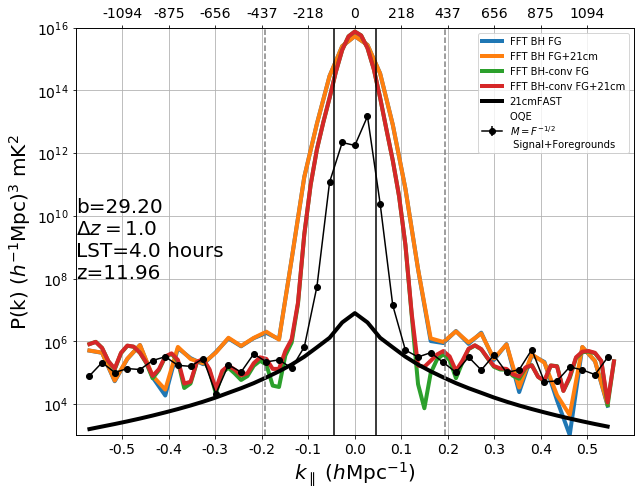

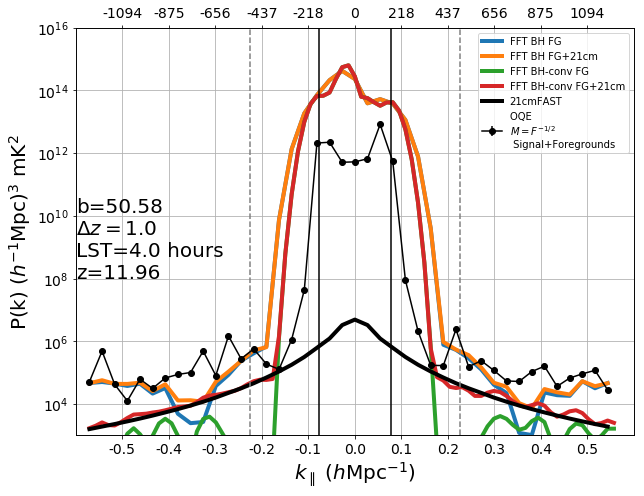

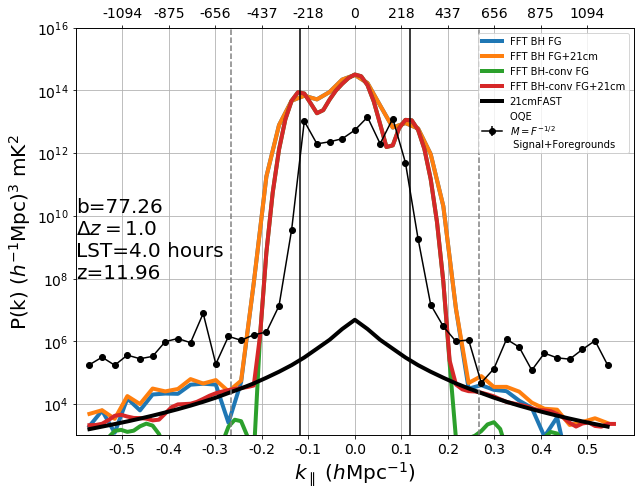

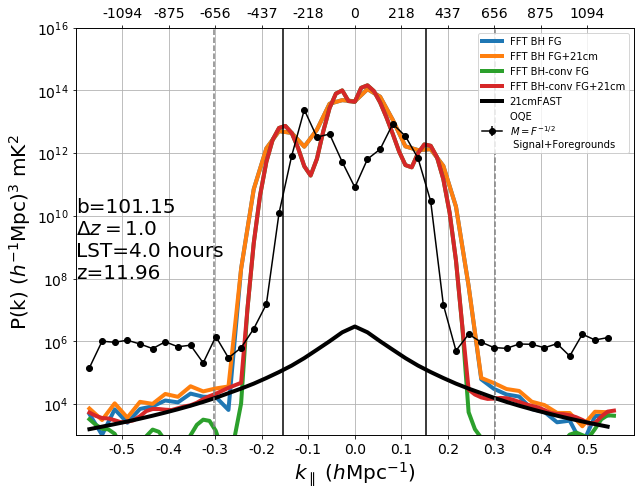

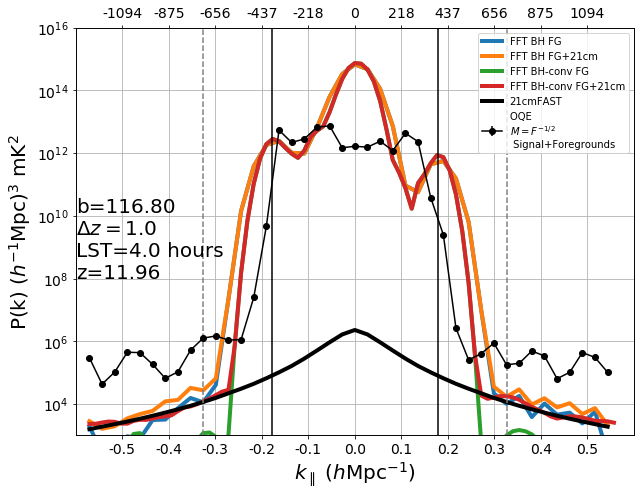

In [33]:
nPSAvg=20
for blindex in [0,5,9,19,29]:
    freqs=data['freq']
    lst=60.
    delta_z=1.0
    lstbin=n.where(n.abs(data['lst']-lst)==n.abs(data['lst']-lst).min())[0][0]
    zcList=n.array([12.])
    fcList=cosmology.z2f(zcList)
    fcList=cosmology.z2f(zcList)
    uvw_l=data['bl_length'][blindex]*c/fcList[0]
    bwidths=-cosmology.dz2df(2*delta_z,zcList)
    bwidths_c=2.*bwidths
    flows_c=fcList-bwidths_c/2
    fhighs_c=fcList+bwidths_c/2
    flows=fcList-bwidths/2
    fhighs=fcList+bwidths/2
    mm=0
    select=n.logical_and(freqs>flows[mm],freqs<=fhighs[mm])
    select_c=n.logical_and(freqs>flows_c[mm],freqs<=fhighs_c[mm])
    freqs_select=freqs[select]
    freqs_select_c=freqs[select_c]
    nfs=len(freqs_select)
    nfs_c=len(freqs_select_c)
    if(n.mod(nfs,2)==1):
            maxind=n.where(select)[0].max()
            select[maxind+1]=True
            nfs+=1
            freqs_select=freqs[select]
    if(n.mod(nfs_c,2)==1):
            maxind=n.where(select_c)[0].max()
            select_c[maxind+1]=True
            nfs_c+=1
            freqs_select_c=freqs[select_c]        

    band_select=(freqs_select.max()-freqs_select.min())
    band_select_c=(freqs_select_c.max()-freqs_select_c.min())

    delayList=n.arange(-(nfs-1)/2,(nfs-1)/2+1)/(nfs*df)
    delayList_c=n.arange(-(nfs_c-1)/2,(nfs_c-1)/2+1)/(nfs_c*df)


    fGrid,fGridp=n.meshgrid(freqs_select,freqs_select)
    fGrid_c,fGridp_c=n.meshgrid(freqs_select_c,freqs_select_c)
    ps_fft_fg=n.zeros(nfs);ps_cfft_fg=n.zeros(nfs_c);ps_fft_fgs=n.zeros(nfs)
    ps_cfft_fgs=n.zeros(nfs_c);ps_oqe=n.zeros(nfs);ps_sig=n.zeros(nfs)

    for psIndex in range(nPSAvg):
        psSignalModels=n.zeros((1,nfs))
        psSignalModels_c=n.zeros((1,nfs_c))
        psSignalInstances=n.zeros_like(data['skyvis_freq'][:,select,lstbin])
        psSignalInstances_c=n.zeros_like(data['skyvis_freq'][:,select_c,lstbin])

     
        psSignalModels,psSignalInstances=gen_ps_signal(freqs_select,data['bl_length'][blindex]/3e8*fcList[0],beamP[nf/2,1]*df*nfs,ntimes=data['lst'].shape[0])
        psSignalModels_c,psSignalInstances_c=gen_ps_signal(freqs_select_c,data['bl_length'][blindex]/3e8*fcList[0],beamP[nf/2,1]*df*nfs_c,ntimes=data['lst'].shape[0])
        psSignalViss=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances,axes=[0]),axis=0),axes=[0])/(df)
        psSignalViss_c=fft.fftshift(fft.ifft(fft.fftshift(psSignalInstances_c,axes=[0]),axis=0),axes=[0])/(df)
        #print(psSignalModels.shape);print(psSignalViss.shape);print(psSignalViss_c.shape)
        psSignalVis=psSignalViss
        psSignalVis_c=psSignalViss_c
        #print psSignalVis.shape
        #print psSignalVis_c.shape
        windowSignal,dtrans_signal=delayTransform(psSignalVis,df,window=n.ones(nfs))
        windowSignal_c,dtrans_signal_c=delayTransform(psSignalVis_c,df,window=n.ones(nfs_c))
        psSig=delay2PS(dtrans_signal,beamP[select,1][nfs/2],band_select,fcList[0])
        psSig_c=delay2PS(dtrans_signal_c,beamP[select_c,1][nfs_c/2],band_select_c,fcList[0])

        lstSelect=n.logical_and(data['lst']>0, data['lst']<360.)

        #print 'computing data covariance'
        fgCov,fgCovI=empCov_avgLST(data['skyvis_freq'][:,select,:][:,:,lstSelect]+1*psSignalViss[:,lstSelect],rFactor=0)
        #print 'compute resid covariance'
        fgCovR,fgCovIR=empCov_avgLST(resid[:,select,:][:,:,lstSelect]+1*psSignalViss[:,lstSelect],rFactor=0)


        fgCov=fgCov[blindex].squeeze()
        fgCovI=fgCovI[blindex].squeeze()
        fgCovIR=fgCovIR[blindex].squeeze()


        myMode='F^-1/2'
        
        psSignalVis=psSignalVis[:,lstbin]
        psSignalVis_c=psSignalVis_c[:,lstbin]
        
        qHatR,pHatR,wMatR,fMatR,qMatrices=oqeFunc(resid[blindex,select,lstbin]+1*psSignalVis,cInv=fgCovIR,mode=myMode)

        qHat,pHat,wHat,_,_=oqeFunc(data['skyvis_freq'][blindex,select,lstbin]+1*psSignalVis,wF=sig.blackmanharris(nfs),cInv=fgCovI,mode=myMode)

        qHatT,pHatT,_,_,_=oqeFunc(psSignalVis,wF=n.ones(nfs),cInv=None,mode='I')

        pHatB=n.sqrt(pHat*(df*nfs)**2.)
        pHatB_e=n.sqrt(n.sqrt(n.abs(n.diagonal(wHat)))*(df*nfs)**2.)
        pHatBR=n.sqrt(pHatR*(df*nfs)**2.)
        pHatBT=n.sqrt(pHatT*(df*nfs)**2.)


        pHatPS=delay2PS(pHatB,beamP[0,0],band_select,fcList[0])
        pHatPS_e=delay2PS(pHatB_e,beamP[0,0],band_select,fcList[0])

        pHatPSR=delay2PS(pHatBR,beamP[0,0],band_select,fcList[0])
        pHatPST=delay2PS(pHatBT,beamP[0,0],band_select,fcList[0])


        nFactorResponse=n.sqrt(n.mean(n.abs(antKernel)[n.logical_and(freqs>flows[0],freqs<=fhighs[0])]**2.))/n.sqrt(n.mean(n.abs((antKernel)[select])**2.))
        nFactor=1.#np.abs(window).max()/np.abs((window)[select]).max()
        nFactorResponse=1.
        fcs=freqs_select[len(freqs_select)/2]

        dtrans_list,_=delayTransformList([data['skyvis_freq'][[blindex],select,lstbin].T*nFactor],df)
        dtrans_list_bh2,_=delayTransformList([data['skyvis_freq'][[blindex],select_c,lstbin].T*nFactor],df,window='blackman-conv')
        dtrans_list_sig,_=delayTransformList([data['skyvis_freq'][[blindex],select,lstbin].T*nFactor+psSignalVis],df)
        dtrans_list_sig_bh2,_=delayTransformList([data['skyvis_freq'][[blindex],select_c,lstbin].T*nFactor+psSignalVis_c],df,window='blackman-conv')
        #dtrans_conv_list,_=delayTransformList([data_conv[:,select,lstbin].T*nFactorResponse],df)
        #dtrans_conv_list_bh2,_=delayTransformList([data_conv[:,select_c,lstbin].T*nFactorResponse],df,window='blackman-conv')
        #dtrans_resid_list,_=delayTransformList([resid[:,select,lstbin].T*nFactor],df)
        #dtrans_resid_list_bh2,_=delayTransformList([resid[:,select_c,lstbin].T*nFactor],df,window='blackman-conv')
        #dtrans_conv_resid_list,windows=delayTransformList([conv_resid[:,select,lstbin].T*nFactorResponse],df)
        #dtrans_conv_resid_list_bh2,_=delayTransformList([conv_resid[:,select_c,lstbin].T*nFactorResponse],df,window='blackman-conv')

        ps_list=delay2PSList(dtrans_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        ps_list_sig=delay2PSList(dtrans_list_sig,[beamP[select,1][nfs/2]],[band_select],[fcs])
        ps_list_bh2=delay2PSList(dtrans_list_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        ps_list_sig_bh2=delay2PSList(dtrans_list_sig_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        #ps_conv_list=delay2PSList(dtrans_conv_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        #ps_conv_list_bh2=delay2PSList(dtrans_conv_list_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        #ps_resid_list=delay2PSList(dtrans_resid_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        #ps_resid_list_bh2=delay2PSList(dtrans_resid_list_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        #ps_conv_resid_list=delay2PSList(dtrans_conv_resid_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        #ps_conv_resid_list_bh2=delay2PSList(dtrans_conv_resid_list_bh2,[beamP[select_c,1][nfs_c/2]],[band_select_c],[fcs])
        z0=cosmology.f2z(fcs)

        #tuvw=data['bl_length'][:,lstbin]
        #print tuvw
        #uvw_l=n.sqrt(n.sum(tuvw**2.))/c*freqs_select[nfs/2]
        #print uvw_l
        #signalPS=gen_ps_signal(freqs_select,uvw_l,beamP[select,1][nfs/2],flux=False)
        #signalPS=signalPS[0]*signalPS[0]*littleh**3.
        
        ps_fft_fg+=ps_list[0][:]
        ps_cfft_fg+=ps_list_bh2[0][:]
        ps_fft_fgs+=ps_list_sig[0][:]
        ps_cfft_fgs+=ps_list_sig_bh2[0][:]
        ps_oqe+=pHatPS
        ps_sig+=psSig[:,lstbin]
    ps_fft_fg/=nPSAvg;ps_cfft_fg/=nPSAvg;
    ps_fft_fgs/=nPSAvg;ps_cfft_fgs/=nPSAvg;
    ps_oqe/=nPSAvg;ps_sig/=nPSAvg
    
    fig=p.figure()
    ax1=fig.add_subplot(111)

    kList=cosmology.eta2kpara((delayList),z0)
    #kList=n.sign(kList)*n.sqrt(kList**2.+cosmology.u2kperp(uvw_l,z0)**2.)
    kList_c=cosmology.eta2kpara((delayList_c),z0)
    #kList_c=n.sign(kList_c)*n.sqrt(kList_c**2.+cosmology.u2kperp(uvw_l,z0)**2.)
    l0=ax1.plot(kList/littleh,ps_fft_fg,label='FFT BH FG',lw=4)[0]
    l2=ax1.plot(kList/littleh,ps_fft_fgs,label='FFT BH FG+21cm',lw=4)[0]
    l1=ax1.plot(kList_c/littleh,ps_cfft_fg,label='FFT BH-conv FG',lw=4)[0]
    l3=ax1.plot(kList_c/littleh,ps_cfft_fgs,label='FFT BH-conv FG+21cm',lw=4)[0]

    #l1=ax1.plot(kList/littleh,ps_conv_list[0][:,blindex],label='Beam\n with Response Function',lw=4)[0]

    #l2=ax1.plot(kList/littleh,ps_resid_list[0][:,blindex],label='FFT Power Spectrum\nClean Residuals',ls='--',lw=4)[0]
    #l3=ax1.plot(kList/littleh,ps_conv_resid_list[0][:,blindex],label='Residuals\n with Reflection',ls='--',lw=4)[0]

    #l6=ax1.plot(kList/littleh,pHatPSR,label='Empirical Covariance\n$M=F^{-1/2}$ \n Signal+Clean Residuals',color='grey',marker='d',markersize=10)[0]
    l4=ax1.errorbar(kList/littleh,pHatPS,pHatPS_e,label='OQE \n$M=F^{-1/2}$ \n Signal+Foregrounds',color='k',marker='o')[0]

    #l5=ax1.errorbar(kList/littleh,psSig[:,lstbin],psSig[:,lstbin],label='FFT Power Spectrum\nSignal Only',color='m',marker='d',markersize=10)[0]


    #l7=ax1.plot(kList/littleh,pHatPST,label='Identity Covariance\nIdentity M\n Signal Only',color='m',marker='d',markersize=10)[0]


    #l8=ax1.plot(kList/littleh,pHatPSAP[:,lstbin],label='ap',color='orange',marker='d',markersize=10)[0]
    #l9=ax1.plot(kList/littleh,pHatPSAPI,label='ap',color='orange',marker='o',markersize=10)[0]
    #l10=ax1.plot(kList/littleh,pHatPSAPT[:,lstbin],label='Identity Covarianc\nIdentity M\nSignal Only',color='red',marker='*',markersize=10)[0]


    hz=cosmology.eta2kpara(uvw_l/freqs_select[nfs/2],z0)/littleh
    psSignalModels=delay2PS(psSignalModels,beamP[select,1][nfs/2],band_select,fcs)
    ls=ax1.plot(kList[::]/littleh,psSignalModels,color='k',lw=4,label='21cmFAST')[0]

    ax1.set_yscale('log')

    ax1.set_xlabel('$k_\parallel$ ($h$Mpc$^{-1}$)',fontsize=20)
    ax1.set_ylabel('P(k) ($h^{-1}$Mpc)$^{3}$ mK$^2$',fontsize=20)
    #        ax1.set_title('z=%.1f,u=%.1f$\\lambda$'%(cosmology.f2z(fcs),uvw_l),fontsize=30,y=1.1)
    ax1.tick_params('x',labelsize=14)
    ax1.tick_params('y',labelsize=14)

    ax1.axvline((cosmology.eta2kpara(data['bl_length'][blindex]/c,z0))/littleh,color='k',ls='-')
    ax1.axvline(-(cosmology.eta2kpara(data['bl_length'][blindex]/c,z0))/littleh,color='k',ls='-')


    ax1.axvline((cosmology.eta2kpara(325e-9+data['bl_length'][blindex]/c,z0))/littleh,color='grey',ls='--')
    ax1.axvline(-(cosmology.eta2kpara(325e-9+data['bl_length'][blindex]/c,z0))/littleh,color='grey',ls='--')
    
    ax1.grid(b=True,which='major')
    ax1.grid(b=True,which='minor')
    #ax1.text(.2,1.5e11,'z=%.1f'%(zcList[0]),fontsize=16)
    p.legend(loc='best',ncol=1,fontsize=10)
    tickset=n.arange(-5,6)*.1
    ax1.set_xticks(tickset)
    labels=[]
    for tick in tickset:
            labels.append(str(tick))


    ax1.set_xticklabels(labels)
    ax1.set_ylim(1e3,1e16)

    ax2=ax1.twiny()
    ticks=ax1.get_xticks()
    labels=[]
    for tick in ticks:
        labels.append('%d'%(1e9*cosmology.kpara2eta(littleh*tick,cosmology.f2z(fcs))))
    ax2.set_xticks(ticks)
    ax1.set_xlim(-.6,.6)
    ax2.set_xlim(ax1.get_xlim())
    #if(ii==0):
    #    ax2.set_xlabel('delay (ns)',fontsize=20)
    ax2.set_xticklabels(labels)
    ax2.tick_params('x',labelsize=14)
    ax2.tick_params('y',labelsize=14)
    #ax1.axvline(1/littleh*cosmology.eta2kpara(maxdelay_list[blindex],zcList[mm]),color='k',ls='--')
    #ax1.axvline(-1/littleh*cosmology.eta2kpara(maxdelay_list[blindex],zcList[mm]),color='k',ls='--')
    #ax1.text(0.,1e15,'%.1f m E-W, %.1f m N-S'%(data['bl'][2,0],data['bl'][2,1]),fontsize=24,ha='center')
    #axarr[0][1].text(0.,1e18,'%.1f m E-W, %.1f m N-S'%(data['bl'][blindices[1],0],data['bl'][blindices[1],1]),fontsize=24,ha='center')

    #ax1.legend((l0,l1,ls),('Achromatic\n Beam','Beam with\n Response\n Function','HI signal'),'upper left',ncol=1,fontsize=14)#,bbox_to_anchor=[.45,.03])
    fig.set_size_inches(10,7.5)
    ax1.text(-0.6,1e8,'b=%.2f\n$\\Delta z=%.1f$\nLST=%.1f hours\nz=%.2f'%(data['bl_length'][blindex],delta_z,lst/15.,z0),fontsize=20)
    p.savefig('/Users/aaronew/Dropbox_MIT/Science/simulations-hera-eox/analysis/delay_ps_z%.2f_len%.2f_lst_%.2fh_delta_z_%.2f_long.pdf'%(z0,
                                                                                                                        data['bl_length'][blindex],
                                                                                                                        lst/15.,delta_z),
                                                                                                                        bbox_inches='tight')
    p.show() 

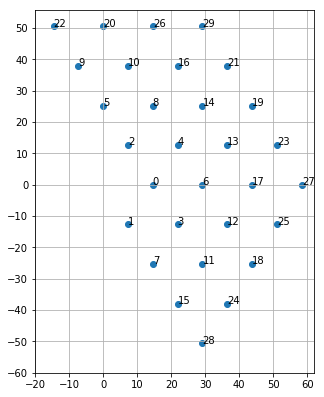

In [24]:
p.scatter(data['bl'][:,0],data['bl'][:,1])
for mm in range(len(data['bl'])):
    p.text(data['bl'][mm,0],data['bl'][mm,1],'%d'%mm)
    
p.gca().set_yticks(n.arange(-60,60,10))
p.gca().set_xticks(n.arange(-20,70,10))
p.gcf().set_size_inches(5,5*(120./90.))
p.grid()

4


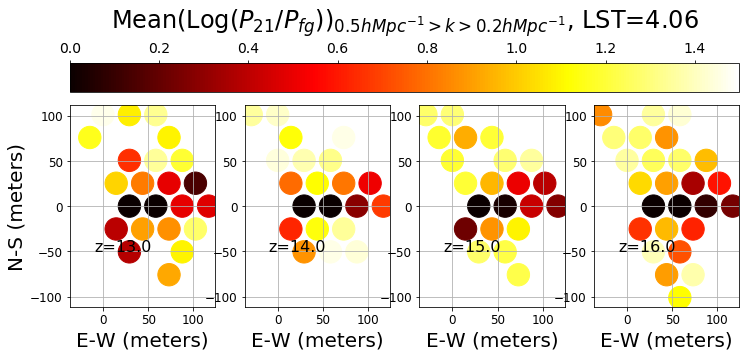

In [76]:
#creat a plot that shows average SNR above kparallel = 0.2 h/Mpc for all baselines

freqs=data['freq']
fig,axarr=p.subplots(1,4)
delta_z=2.
zcList=n.array([7,7.5,8,8.5,9,9.5,10,10.5])
zcList=n.array([13.,14.,15.,16.])
bwidths=-cosmology.dz2df(delta_z,zcList)
lstbin=n.where(n.abs(data['lst']-60.)==n.abs(data['lst']-60.).min())[0][0]
print lstbin
fcList=cosmology.z2f(zcList)
flows=fcList-bwidths/2
fhighs=fcList+bwidths/2

for ii in range(2):
    for jj in range(2):
        mm=ii+jj*2
        select=n.logical_and(freqs>flows[mm],freqs<=fhighs[mm])
        freqs_select=freqs[select]
        nfs=len(freqs_select)
        if(n.mod(nfs,2)==1):
                #find the largest true index and add an additional true on 
            maxind=n.where(select)[0].max()
            select[maxind+1]=True
            nfs+=1
        freqs_select=freqs[select]
        nFactorResponse=n.sqrt(n.mean(n.abs(antKernel)[n.logical_and(freqs>flows[mm],freqs<=fhighs[mm])]**2.))/n.sqrt(n.mean(n.abs((antKernel)[select])**2.))
        nFactor=1.#np.abs(window).max()/np.abs((window)[select]).max()
        band_select=(freqs_select.max()-freqs_select.min())
        fcs=freqs_select[len(freqs_select)/2]
        z0=cosmology.f2z(fcs)
        snrList=[]
        dtrans_list,_=delayTransformList([data['skyvis_freq'][:,select,lstbin].T*nFactor],df,window='blackman-conv')
        dtrans_conv_list,_=delayTransformList([data_conv[:,select,lstbin].T*nFactorResponse],df,window='blackman-conv')
        dtrans_resid_list,_=delayTransformList([resid[:,select,lstbin].T*nFactor],df)
        dtrans_conv_resid_list,windows=delayTransformList([conv_resid[:,select,lstbin].T*nFactorResponse],df)


        ps_list=delay2PSList(dtrans_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        ps_conv_list=delay2PSList(dtrans_conv_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        ps_resid_list=delay2PSList(dtrans_resid_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        ps_conv_resid_list=delay2PSList(dtrans_conv_resid_list,[beamP[select,1][nfs/2]],[band_select],[fcs])
        for blindex in range(data['skyvis_freq'].shape[0]):

            tuvw=data['bl_length'][blindex]
            uvw_l=n.sqrt(n.sum(tuvw**2.))/c*freqs_select[nfs/2]
            delayList=n.arange(-nfs/2,nfs/2)/(nfs*df)
            signalPS=gen_ps_signal(freqs_select,uvw_l,beamP[select,1][nfs/2],flux=False)
            signalPS=signalPS[0]*signalPS[0]*littleh**3.

        
            kList=cosmology.eta2kpara((delayList),z0)/littleh
            ax1=axarr[mm]
            


            hz=cosmology.eta2kpara(uvw_l/freqs_select[nfs/2],z0)/littleh+.15
            mink=n.max([0.2,hz])
            meanSelection=n.logical_and(n.abs(kList)>mink,n.abs(kList)<.5)
            snr=n.mean(n.log10(signalPS[meanSelection]/ps_resid_list[0][meanSelection,blindex]))
            snrList.append(snr)

        n.savez('/Users/aaronew/Dropbox_MIT/Science/simulations-hera-eox/src/log10_snr_long_lst_%.2f_z_%.2f.npz'%(data['lst'][lstbin]/15.,zcList[mm]),
                snr=n.array(snrList),ew=data['bl'][:,0],ns=data['bl'][:,1])
        im=ax1.scatter(data['bl'][:,0],data['bl'][:,1], c=(n.array(snrList)),vmin=0,vmax=1.5,s=500,cmap='hot')
        if mm==0:
            ax1.set_ylabel('N-S (meters)',fontsize=20)
        ax1.set_xlabel('E-W (meters)',fontsize=20)
    #        ax1.set_title('z=%.1f,u=%.1f$\\lambda$'%(cosmology.f2z(fcs),uvw_l),fontsize=30,y=1.1)
        ax1.tick_params('x',labelsize=12)
        ax1.tick_params('y',labelsize=12)
        ax1.grid(b=True,which='major')
        ax1.grid(b=True,which='minor')
        ax1.text(-10,-50,'z=%.1f'%(zcList[mm]),fontsize=16)
        ax1.set_aspect('equal')

            
            
cbar_ax=fig.add_axes([.125,.9,.775,.1])
fig.colorbar(im,cax=cbar_ax,orientation='horizontal')
cbar_ax.set_title('Mean(Log($P_{21}/P_{fg}$))$_{0.5hMpc^{-1}>k>0.2hMpc^{-1}}$, LST=%.2f'%(data['lst'][lstbin]/15.),fontsize=24,y=2)
cbar_ax.xaxis.tick_top()
cbar_ax.tick_params('x',labelsize=14)
            
            
#axarr[0][0].text(.25,1e18,'%.1f m E-W, %.1f m N-S'%(data['bl'][blindex,0],data['bl'][blindex,1]),fontsize=24)
fig.set_size_inches(12,4)
p.savefig('/Users/aaronew/Dropbox_MIT/Science/simulations-hera-eox/analysis/long_snr_plot_eox.pdf',
          bbox_inches='tight')


4
0.0
0.2
0.4
0.6
0.8
1.0


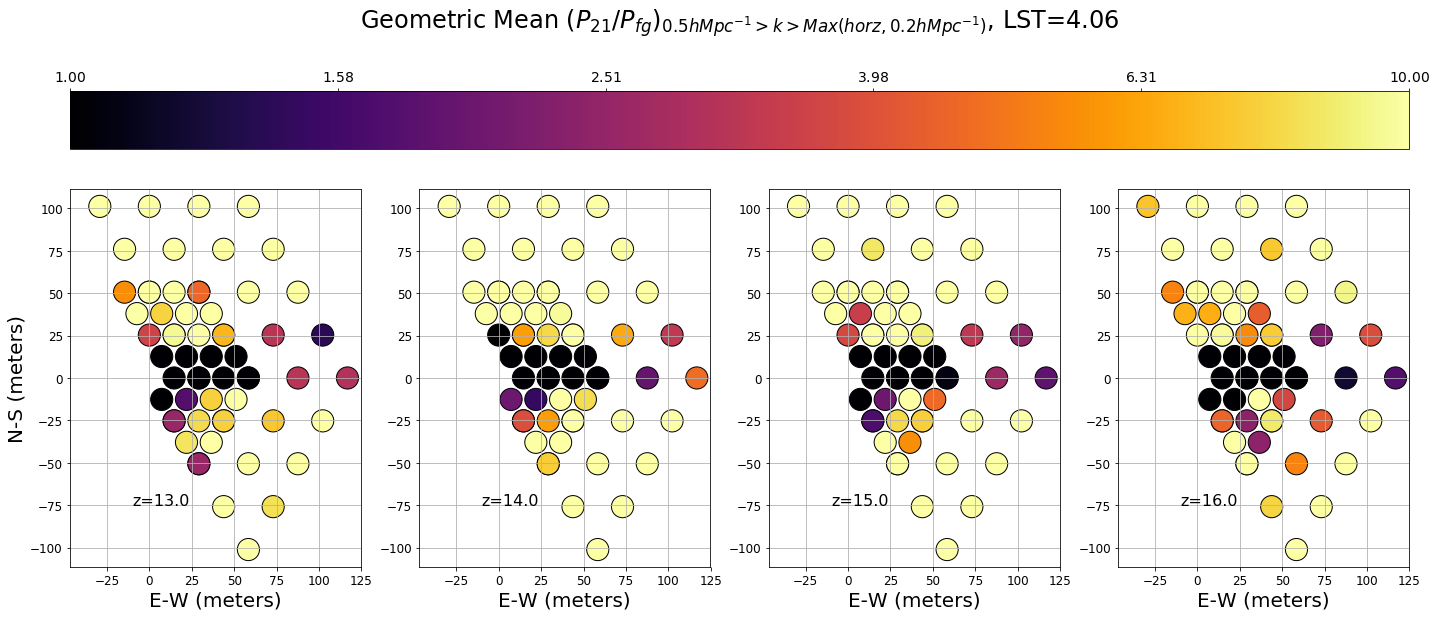

In [87]:
#creat a plot that shows average SNR above kparallel = 0.2 h/Mpc for all baselines

freqs=data['freq']
fig,axarr=p.subplots(1,4)
delta_z=2.
zcList=n.array([7,7.5,8,8.5,9,9.5,10,10.5])
zcList=n.array([13.,14.,15.,16.])
bwidths=-cosmology.dz2df(delta_z,zcList)
lstbin=n.where(n.abs(data['lst']-60.)==n.abs(data['lst']-60.).min())[0][0]
print lstbin
fcList=cosmology.z2f(zcList)
flows=fcList-bwidths/2
fhighs=fcList+bwidths/2

for ii in range(2):
    for jj in range(2):
        mm=ii+jj*2


        
        ax1=axarr[mm]


        snr_long=n.load('/Users/aaronew/Dropbox_MIT/Science/simulations-hera-eox/src/log10_snr_long_lst_%.2f_z_%.2f.npz'%(data['lst'][lstbin]/15.,zcList[mm]))
        snr_short=n.load('/Users/aaronew/Dropbox_MIT/Science/simulations-hera-eox/src/log10_snr_short_lst_%.2f_z_%.2f.npz'%(data['lst'][lstbin]/15.,zcList[mm]))
        sarea=n.pi*7**2.
        sarea=2.5*14.**2.
        im=ax1.scatter(snr_long['ew'],snr_long['ns'], c=snr_long['snr'],vmin=0,vmax=1,s=sarea,cmap='inferno',edgecolor='k')
        im=ax1.scatter(snr_short['ew'],snr_short['ns'], c=snr_short['snr'],vmin=0,vmax=1,s=sarea,cmap='inferno',edgecolor='k')


        if mm==0:
            ax1.set_ylabel('N-S (meters)',fontsize=20)
        ax1.set_xlabel('E-W (meters)',fontsize=20)
    #        ax1.set_title('z=%.1f,u=%.1f$\\lambda$'%(cosmology.f2z(fcs),uvw_l),fontsize=30,y=1.1)
        ax1.tick_params('x',labelsize=12)
        ax1.tick_params('y',labelsize=12)
        ax1.grid(b=True,which='major')
        ax1.grid(b=True,which='minor')
        ax1.text(-10,-75,'z=%.1f'%(zcList[mm]),fontsize=16)
        ax1.set_aspect('equal')

            
            
cbar_ax=fig.add_axes([.125,.9,.775,.1])
fig.colorbar(im,cax=cbar_ax,orientation='horizontal')
cbar_ax.set_title('Geometric Mean ($P_{21}/P_{fg}$)$_{0.5hMpc^{-1}>k>Max(horz,0.2hMpc^{-1})}$, LST=%.2f'%(data['lst'][lstbin]/15.),fontsize=24,y=2)
cbar_ax.xaxis.tick_top()
cbar_ax.tick_params('x',labelsize=14)
cb_labels=[]
for tick in cbar_ax.get_xticks():
    print tick
    cb_labels.append('$%.2f$'%(10**(tick)))
cbar_ax.set_xticklabels(cb_labels)
            
#axarr[0][0].text(.25,1e18,'%.1f m E-W, %.1f m N-S'%(data['bl'][blindex,0],data['bl'][blindex,1]),fontsize=24)
fig.set_size_inches(24,8)
p.savefig('/Users/aaronew/Dropbox_MIT/Science/simulations-hera-eox/analysis/all_spacings_snr_plot_eox_halfplane.pdf',
          bbox_inches='tight')

